# LAVD and Lagrangian eddies

## Just a little info about the code

Created on: 13.09.2024

Last edited: 17.09.2024

Created by: Stella Bērziņa (stella.berzina@usys.eth.ch)

This notebook aims to document how to calculate LAVD fields from taking input velocity fields from ICON EERIE runs. After LAVD fields are calculated, RCLVs are identified in the fields. Tracking of the RCLVs is also shown. 

This notebook is heavily based on Lexi Jones-Kellett (MIT) example_usage.ipynb which is published along with her code. The functions in this notebook are a combination of **RCLVatlas** by Lexi Jones-Kellett (MIT) (https://github.com/lexi-jones/RCLVatlas) and **xlcs** by Philippe Miron (https://github.com/philippemiron/xlcs). Both initially use **Parcels**  (https://github.com/OceanParcels/Parcels) to create the Lagrangian trajectories and the **Floater** (https://github.com/ocean-transport/floater) to identify the RCLVs. 

My job here is to take the bits that I like from other people's work and alter it to work with the model output data that I have (which I also did not create). So thanks to about a million people for working for years so that I could do this.

## Python Environment
**DOCUMENT LATER**


I would follow the installation steps noted down in RCLVatlas (https://github.com/lexi-jones/RCLVatlas) to have an environment where Parcels runs. 
Also, to make the intake library run, there are a couple of packages

## LAVD calculation

**Input data:**  ICON, 0.25 regridded velocity fields from the intake catalog.

**Output data:** lagrangian trajectories folder, LAVD field.

The run_parcels_CMEMC.py file is changed from the original by feeding in EERIE intake catalogue and uses functions from xlcs package

### How to run the LAVD and lagrangian trajectory calculation:

1. Activate parcels environment in your terminal by running
   `conda activate parcels_environment`
2. Go into the path in your directory where the RCLVatlas package is stored
   `cd ./RCLVatlas/`
1. Setup the config.py file with the following params (default):
- grid_bounds = {
               'lon_bound_west':350.0,
               'lon_bound_east':10.0,
               'lat_bound_south':-80.0,
               'lat_bound_north':80.0,
               'lag_grid_res':0.03125
               }

# there currently is an error with boundaries and lagrangian particles, that is why we remove 10 deg from either end
  

- sim_params = {
              'runtime':10, 
              'runtime_unit':'days',
              'timestep':20, 
              'output_freq':6,
              'backwards':'y'
              } 

- RCLV_params = {
               'min_dist':24,
               'min_area':104,
               'init_contour_step_frac':0.1,
               'convex_def_tol':0.001
               }

2. Run the following lines in the command line to simulate the Lagrangian trajectories and calculate the Lagrangian averaged vorticity deviation (LAVD)
- `python run_parcels_CMEMS.py 20020410`
- `python run_parcels_CMEMS.py 20020420`
- `python run_parcels_CMEMS.py 20020430`

At this point, you will have 3 10-day backward-in-time Lagrangian trajectories calculated for a 5x5 degree box near Hawaii. You will also have the LAVD calculated for each of these runs, which will be used to identify RCLVs. 

# Plotting LAVD

The following code is heavily based on RCLVatlas example_usage notebook

In [1]:
import os,sys
import trajan
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from config import *

sys.path.append('./RCLVatlas')
from subfunctions_for_RCLV_atlas import read_RCLV_CSV_untracked,read_RCLV_CSV_tracked,save_RCLV_CSV
from mainfunctions_for_RCLV_atlas import *


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
dates = [filename[0:8] for filename in os.listdir(LAVD_dir)]
date_list = np.sort(np.unique(dates)).tolist()[::-1] #Reverse the order because we will iterate from the latest date to the earliest
date_list

['20100712', '20100704', '20100626', '20100618', '20100610']

In [3]:
LAVD_output_file_path = LAVD_dir + date_list[0] + '_LAVD_' + filename_str + '.npy'
LAVD = np.load(LAVD_output_file_path)
LAVD = np.ma.masked_where(np.isnan(LAVD),LAVD) #Land mask required for the peak_local_max function to work
LAVD_reshape = np.transpose(np.reshape(LAVD,(len(traj_lon_array),len(traj_lat_array))))

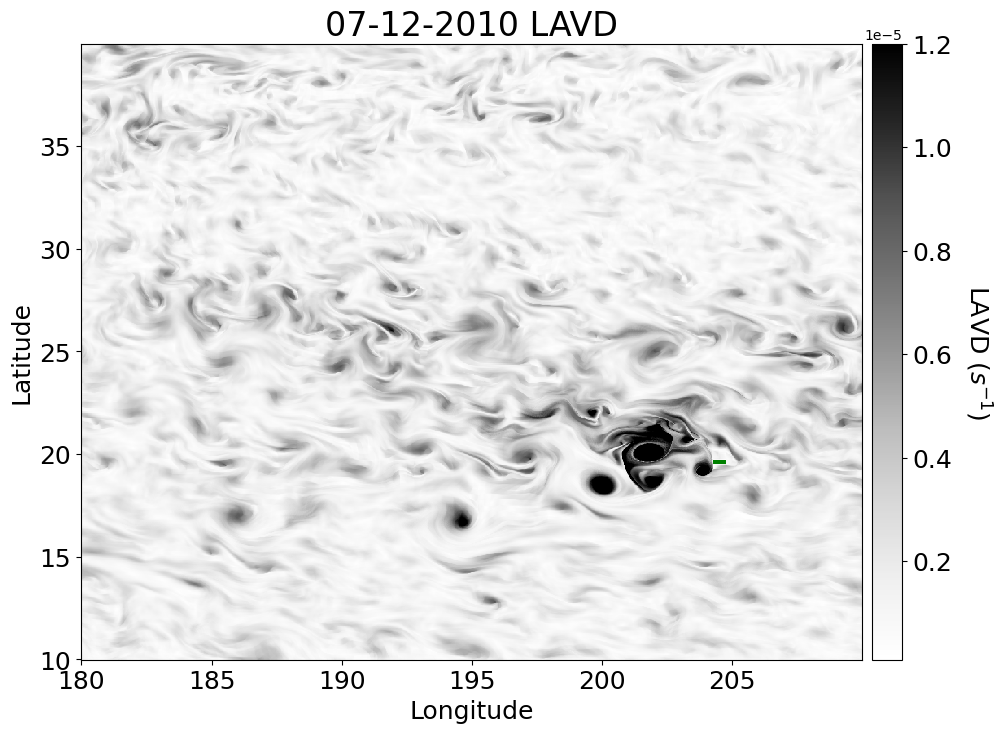

In [4]:
fontsize = 18

fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.set_facecolor("g")
plot = ax.pcolormesh(traj_lon_array,traj_lat_array,LAVD_reshape,shading='nearest',cmap='Greys',vmin=10**(-7), vmax=1.2*(10**(-5)));

cbar = plt.colorbar(plot, pad = 0.01)
cbar.ax.tick_params(labelsize=18)
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('LAVD $(s^{-1})$', rotation=270, fontsize=fontsize)
    
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_title('%s-%s-%s LAVD'%(date_list[0][4:6],date_list[0][6:8],date_list[0][0:4]),fontsize=24)

plt.show()

## Identify RCLVs

**Note to myself**-  IN SUBFUNCTIONS.PY I ADDED INLINES 56-59 THE -1 AFTER THE TIME INDEX BC OTHERWISE IT WAS NOT WORKING ~!!! KEEP THAT IN MIND 


In [5]:
RCLV_data = np.array(set_up_RCLV_atlas(date_list),dtype=object) 
print('Length of RCLV_data: %s'%(len(RCLV_data)))
save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_untracked.csv'%(RCLV_dir,date_list[-1],date_list[0])) #save RCLV as CSV

Identifying RCLVs...
20100712
['/scratch/b/b382618/8day/lang_traj/20100712_8days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr']


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


(811,)
(921600, 32)
0
0
(811,)
(921600, 32)
8
32
(811,)
(921600, 32)
1
4
(160,)
(921600, 32)
0
0
(160,)
(921600, 32)
8
32
(160,)
(921600, 32)
1
4
(1241,)
(921600, 32)
0
0
(1241,)
(921600, 32)
8
32
(1241,)
(921600, 32)
1
4
(1144,)
(921600, 32)
0
0
(1144,)
(921600, 32)
8
32
(1144,)
(921600, 32)
1
4
(162,)
(921600, 32)
0
0
(162,)
(921600, 32)
8
32
(162,)
(921600, 32)
1
4
(149,)
(921600, 32)
0
0
(149,)
(921600, 32)
8
32
(149,)
(921600, 32)
1
4
(279,)
(921600, 32)
0
0
(279,)
(921600, 32)
8
32
(279,)
(921600, 32)
1
4
(175,)
(921600, 32)
0
0
(175,)
(921600, 32)
8
32
(175,)
(921600, 32)
1
4
(146,)
(921600, 32)
0
0
(146,)
(921600, 32)
8
32
(146,)
(921600, 32)
1
4
(120,)
(921600, 32)
0
0
(120,)
(921600, 32)
8
32
(120,)
(921600, 32)
1
4
(139,)
(921600, 32)
0
0
(139,)
(921600, 32)
8
32
(139,)
(921600, 32)
1
4
(96,)
(921600, 32)
0
0
(96,)
(921600, 32)
8
32
(96,)
(921600, 32)
1
4
(234,)
(921600, 32)
0
0
(234,)
(921600, 32)
8
32
(234,)
(921600, 32)
1
4
(300,)
(921600, 32)
0
0
(300,)
(921600, 32)
8
32

/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


(232,)
(921600, 32)
0
0
(232,)
(921600, 32)
8
32
(232,)
(921600, 32)
1
4
(1216,)
(921600, 32)
0
0
(1216,)
(921600, 32)
8
32
(1216,)
(921600, 32)
1
4
(1513,)
(921600, 32)
0
0
(1513,)
(921600, 32)
8
32
(1513,)
(921600, 32)
1
4
(163,)
(921600, 32)
0
0
(163,)
(921600, 32)
8
32
(163,)
(921600, 32)
1
4
(107,)
(921600, 32)
0
0
(107,)
(921600, 32)
8
32
(107,)
(921600, 32)
1
4
(128,)
(921600, 32)
0
0
(128,)
(921600, 32)
8
32
(128,)
(921600, 32)
1
4
(99,)
(921600, 32)
0
0
(99,)
(921600, 32)
8
32
(99,)
(921600, 32)
1
4
(106,)
(921600, 32)
0
0
(106,)
(921600, 32)
8
32
(106,)
(921600, 32)
1
4
(361,)
(921600, 32)
0
0
(361,)
(921600, 32)
8
32
(361,)
(921600, 32)
1
4
(248,)
(921600, 32)
0
0
(248,)
(921600, 32)
8
32
(248,)
(921600, 32)
1
4
(139,)
(921600, 32)
0
0
(139,)
(921600, 32)
8
32
(139,)
(921600, 32)
1
4
(111,)
(921600, 32)
0
0
(111,)
(921600, 32)
8
32
(111,)
(921600, 32)
1
4
(205,)
(921600, 32)
0
0
(205,)
(921600, 32)
8
32
(205,)
(921600, 32)
1
4
(181,)
(921600, 32)
0
0
(181,)
(921600, 32)
8
32

/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


(105,)
(921600, 32)
0
0
(105,)
(921600, 32)
8
32
(105,)
(921600, 32)
1
4
(764,)
(921600, 32)
0
0
(764,)
(921600, 32)
8
32
(764,)
(921600, 32)
1
4
(1198,)
(921600, 32)
0
0
(1198,)
(921600, 32)
8
32
(1198,)
(921600, 32)
1
4
(108,)
(921600, 32)
0
0
(108,)
(921600, 32)
8
32
(108,)
(921600, 32)
1
4
(598,)
(921600, 32)
0
0
(598,)
(921600, 32)
8
32
(598,)
(921600, 32)
1
4
(185,)
(921600, 32)
0
0
(185,)
(921600, 32)
8
32
(185,)
(921600, 32)
1
4
(131,)
(921600, 32)
0
0
(131,)
(921600, 32)
8
32
(131,)
(921600, 32)
1
4
(157,)
(921600, 32)
0
0
(157,)
(921600, 32)
8
32
(157,)
(921600, 32)
1
4
(1064,)
(921600, 32)
0
0
(1064,)
(921600, 32)
8
32
(1064,)
(921600, 32)
1
4
(119,)
(921600, 32)
0
0
(119,)
(921600, 32)
8
32
(119,)
(921600, 32)
1
4
(95,)
(921600, 32)
0
0
(95,)
(921600, 32)
8
32
(95,)
(921600, 32)
1
4
(139,)
(921600, 32)
0
0
(139,)
(921600, 32)
8
32
(139,)
(921600, 32)
1
4
(124,)
(921600, 32)
0
0
(124,)
(921600, 32)
8
32
(124,)
(921600, 32)
1
4
(226,)
(921600, 32)
0
0
(226,)
(921600, 32)
8
32

/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


(251,)
(921600, 32)
0
0
(251,)
(921600, 32)
8
32
(251,)
(921600, 32)
1
4
(1121,)
(921600, 32)
0
0
(1121,)
(921600, 32)
8
32
(1121,)
(921600, 32)
1
4
(752,)
(921600, 32)
0
0
(752,)
(921600, 32)
8
32
(752,)
(921600, 32)
1
4
(752,)
(921600, 32)
0
0
(752,)
(921600, 32)
8
32
(752,)
(921600, 32)
1
4
(752,)
(921600, 32)
0
0
(752,)
(921600, 32)
8
32
(752,)
(921600, 32)
1
4
(109,)
(921600, 32)
0
0
(109,)
(921600, 32)
8
32
(109,)
(921600, 32)
1
4
(633,)
(921600, 32)
0
0
(633,)
(921600, 32)
8
32
(633,)
(921600, 32)
1
4
(96,)
(921600, 32)
0
0
(96,)
(921600, 32)
8
32
(96,)
(921600, 32)
1
4
(421,)
(921600, 32)
0
0
(421,)
(921600, 32)
8
32
(421,)
(921600, 32)
1
4
(126,)
(921600, 32)
0
0
(126,)
(921600, 32)
8
32
(126,)
(921600, 32)
1
4
(94,)
(921600, 32)
0
0
(94,)
(921600, 32)
8
32
(94,)
(921600, 32)
1
4
(538,)
(921600, 32)
0
0
(538,)
(921600, 32)
8
32
(538,)
(921600, 32)
1
4
(133,)
(921600, 32)
0
0
(133,)
(921600, 32)
8
32
(133,)
(921600, 32)
1
4
(131,)
(921600, 32)
0
0
(131,)
(921600, 32)
8
32
(131,

/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


(153,)
(921600, 32)
0
0
(153,)
(921600, 32)
8
32
(153,)
(921600, 32)
1
4
(579,)
(921600, 32)
0
0
(579,)
(921600, 32)
8
32
(579,)
(921600, 32)
1
4
(199,)
(921600, 32)
0
0
(199,)
(921600, 32)
8
32
(199,)
(921600, 32)
1
4
(142,)
(921600, 32)
0
0
(142,)
(921600, 32)
8
32
(142,)
(921600, 32)
1
4
(170,)
(921600, 32)
0
0
(170,)
(921600, 32)
8
32
(170,)
(921600, 32)
1
4
(114,)
(921600, 32)
0
0
(114,)
(921600, 32)
8
32
(114,)
(921600, 32)
1
4
(236,)
(921600, 32)
0
0
(236,)
(921600, 32)
8
32
(236,)
(921600, 32)
1
4
(119,)
(921600, 32)
0
0
(119,)
(921600, 32)
8
32
(119,)
(921600, 32)
1
4
(229,)
(921600, 32)
0
0
(229,)
(921600, 32)
8
32
(229,)
(921600, 32)
1
4
(277,)
(921600, 32)
0
0
(277,)
(921600, 32)
8
32
(277,)
(921600, 32)
1
4
(146,)
(921600, 32)
0
0
(146,)
(921600, 32)
8
32
(146,)
(921600, 32)
1
4
(242,)
(921600, 32)
0
0
(242,)
(921600, 32)
8
32
(242,)
(921600, 32)
1
4
(411,)
(921600, 32)
0
0
(411,)
(921600, 32)
8
32
(411,)
(921600, 32)
1
4
(177,)
(921600, 32)
0
0
(177,)
(921600, 32)
8
32
(1

## Tracking eddies 

Currently there is an issue where if the last (???) day does not have any RCLVs then it does not finish the tracking.

In [6]:
RCLV_data = np.array(read_RCLV_CSV_untracked('%sRCLV_%s_%s_untracked.csv'%(RCLV_dir,date_list[-1],date_list[0]),1),dtype=object)
RCLV_data = track_and_ID_RCLVs(RCLV_data,date_list)
save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_tracked_with_ID.csv'%(RCLV_dir,date_list[-1],date_list[0])) # Save the tracked data as a CSV

Tracking eddies through time & IDing...
Number of identical contours to remove: 0
20100706


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warni

20100702


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warni

20100628


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warni

20100624


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warni

20100620


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warni

20100616


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warni

20100612


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warni

20100608
20100604


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


Somewhat of a QC step. I currently don't do the interpolation because it gave me errors and I can live without it

In [7]:
log_file = open('%sRCLV_%s_%s_log_file.txt'%(RCLV_dir,date_list[-1],date_list[0]),'a')
RCLV_data = read_RCLV_CSV_tracked('%sRCLV_%s_%s_tracked_with_ID.csv'%(RCLV_dir,date_list[-1],date_list[0]))    
# RCLV_data = interpolate_skipped_contours(RCLV_data,log_file,date_list)
# save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_skips_interpolated.csv'%(RCLV_dir,date_list[-1],date_list[0]))

In [8]:
# RCLV_data = read_RCLV_CSV_tracked('%sRCLV_%s_%s_skips_interpolated.csv'%(RCLV_dir,date_list[-1],date_list[0]))
RCLV_data = read_RCLV_CSV_tracked('%sRCLV_%s_%s_tracked_with_ID.csv'%(RCLV_dir,date_list[-1],date_list[0]))

RCLV_data = age_RCLVs(RCLV_data)
save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_atlas.csv'%(RCLV_dir,date_list[-1],date_list[0])) # Save the final dataset
RCLV_data = np.array(RCLV_data,dtype=object)

Giving RCLVs an age & saving the final atlas...


## Eddies + LAVD fiels 

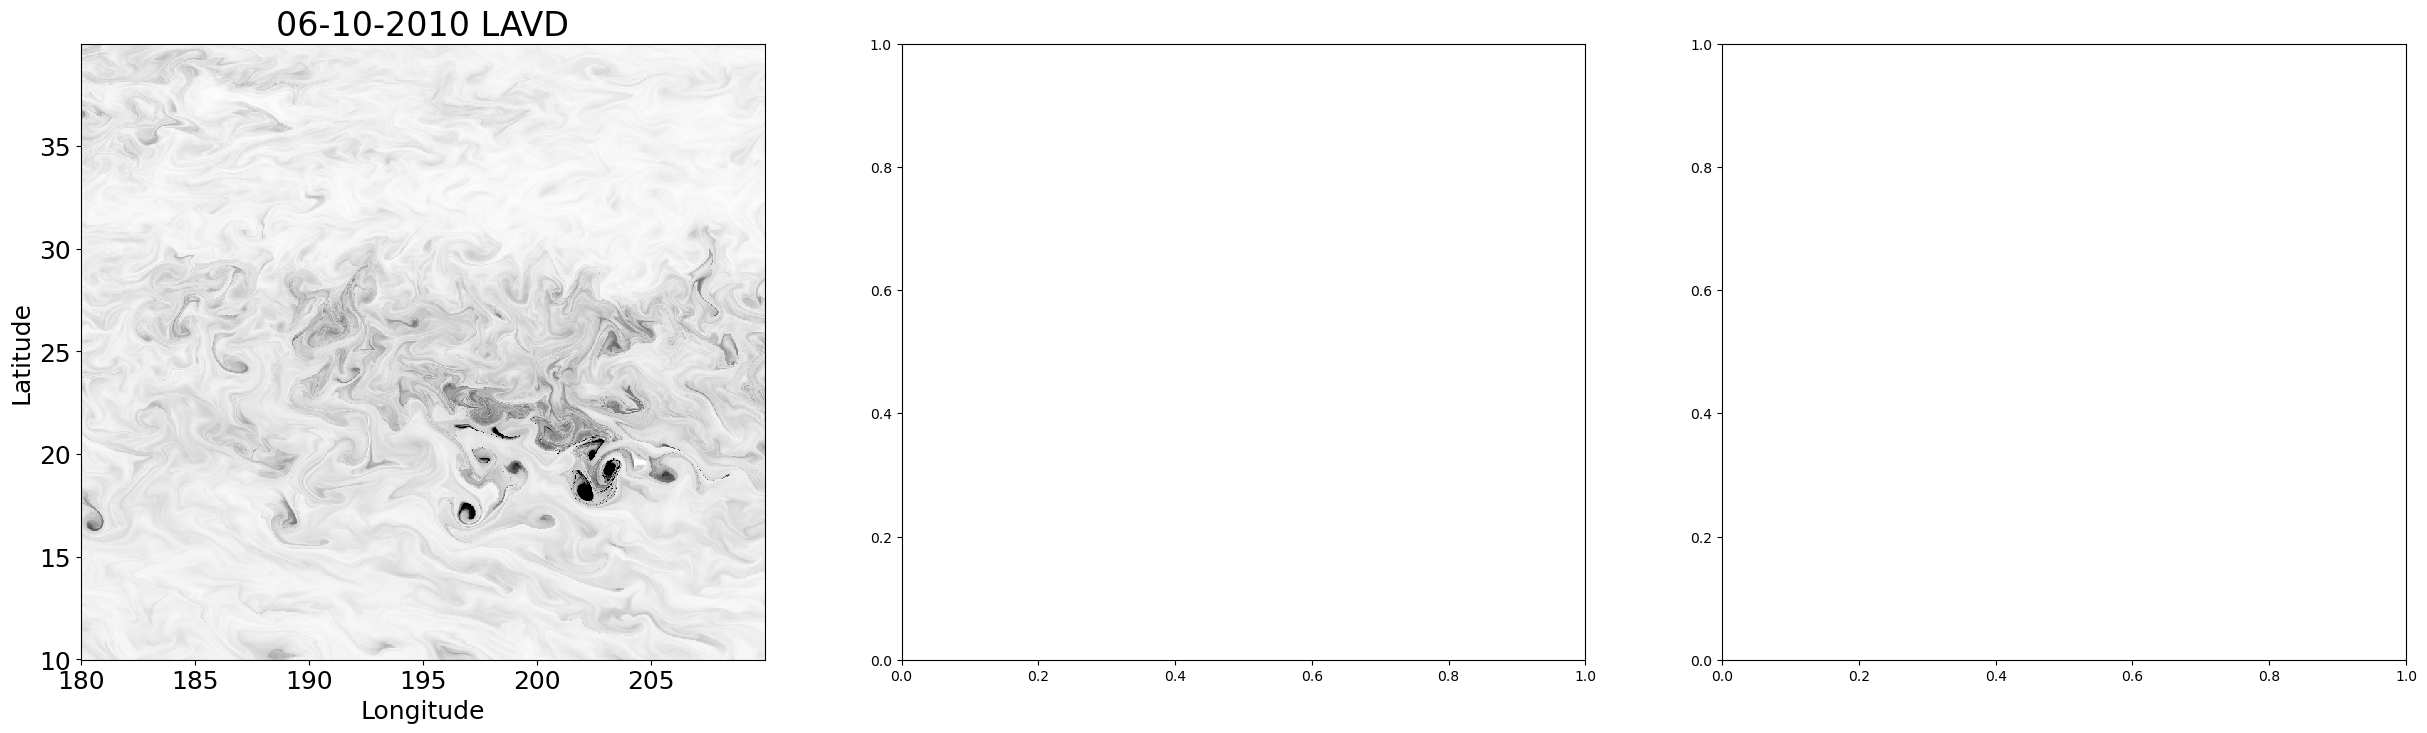

In [6]:
fontsize = 18
fig,ax = plt.subplots(1,3,figsize=(30,8))

ax[0].set_xlabel('Longitude',fontsize=fontsize)
ax[0].set_ylabel('Latitude',fontsize=fontsize)

c = 0
for date in date_list:
    # Load the LAVD data
    LAVD_output_file_path = LAVD_dir + date + '_LAVD_' + filename_str + '.npy'
    LAVD = np.load(LAVD_output_file_path)
    LAVD = np.ma.masked_where(np.isnan(LAVD),LAVD) #Land mask required for the peak_local_max function to work
    LAVD_reshape = np.transpose(np.reshape(LAVD,(len(traj_lon_array),len(traj_lat_array))))
    
    # Plot the LAVD 
    plot = ax[c].pcolormesh(traj_lon_array,traj_lat_array,LAVD_reshape,shading='nearest',cmap='Greys',vmin=10**(-7), vmax=1.2*(10**(-5)));
    ax[c].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[c].set_title('%s-%s-%s LAVD'%(date[4:6],date[6:8],date[0:4]),fontsize=24)

    # Plot the RCLVs for the given date
    RCLV_data_this_day = RCLV_data[np.where([r[0]==date for r in RCLV_data])[0]]
    RCLV_bnds = [r[9:] for r in RCLV_data_this_day] # boundary coordinates
    RCLV_orientations = [r[2] for r in RCLV_data_this_day] # eddy polarity
    
    for i in np.arange(0,len(RCLV_bnds)):
        x_bnds = [float(coord) for coord in RCLV_bnds[i][0::2]]
        y_bnds = [float(coord) for coord in RCLV_bnds[i][1::2]]

        if RCLV_orientations[i] == 'anti':
            color = '#FF0000'
        else:
            color = '#4242FF'
        ax[c].plot(x_bnds,y_bnds,linewidth=5,c=color)
    c += 1

plt.show()

color by RCLV age

In [7]:
RCLV_bnds = [r[9:] for r in RCLV_data[1:]] # boundary coordinates
RCLV_ages = [r[3] for r in RCLV_data[1:]] # ages
norm = colors.Normalize(vmin=min(RCLV_ages), vmax=max(RCLV_ages))

fontsize = 18
fig,ax = plt.subplots(1,1,figsize=(8,8))

for date in date_list:
    for i in np.arange(0,len(RCLV_bnds)):
        x_bnds = [float(coord) for coord in RCLV_bnds[i][0::2]]
        y_bnds = [float(coord) for coord in RCLV_bnds[i][1::2]]
        ax.plot(x_bnds,y_bnds,linewidth=5,c=plt.cm.copper_r(norm(RCLV_ages[i])))
            
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

plt.show()

ValueError: min() arg is an empty sequence